In [1]:
import numpy as np


class Object(object):
    pass


self = Object()
# self.root = '/scratch/gsz/seamless/oivf'
self.root = "/checkpoint/marialomeli/offline_faiss/seamless/sonar"

self.eval_dir = self.root + "/test_eng_0_in_test_glg_0/eval"
self.index_factory_fn = "IVF32768_PQ256"
#self.index_factory_fn = "OPQ256_512_IVF32768_PQ256"
#self.index_factory_fn = "OPQ256_IVF32768_PQ256"
# self.index_factory_fn = 'OPQ128_IVF32768_PQ128'
# self.index_factory_fn = 'OPQ128_512_IVF32768_PQ128'
# self.index_factory_fn = 'IVF32768_PQ128'
# self.index_factory_fn = 'IVF32768_SQ8'
#self.index_factory_fn = 'OPQ64_IVF32768_PQ64'
self.nprobe = 16
self.k = 16

In [2]:
idx_a_file = f"{self.eval_dir}/idx_a.npy"
idx_b_gt_file = f"{self.eval_dir}/idx_b_gt.npy"
idx_b_ann_file = f"{self.eval_dir}/idx_b_ann_{self.index_factory_fn}_np{self.nprobe}.npy"
vecs_a_file = f"{self.eval_dir}/vecs_a.npy"
vecs_b_gt_file = f"{self.eval_dir}/vecs_b_gt.npy"
vecs_b_ann_file = f"{self.eval_dir}/vecs_b_ann_{self.index_factory_fn}_np{self.nprobe}.npy"
D_a_gt_file = f"{self.eval_dir}/D_a_gt.npy"
D_a_ann_file = f"{self.eval_dir}/D_a_ann_{self.index_factory_fn}_np{self.nprobe}.npy"
D_a_ann_refined_file = f"{self.eval_dir}/D_a_ann_refined_{self.index_factory_fn}_np{self.nprobe}.npy"
D_b_gt_file = f"{self.eval_dir}/D_b_gt.npy"
D_b_ann_file = f"{self.eval_dir}/D_b_ann_{self.index_factory_fn}_np{self.nprobe}.npy"
D_b_ann_gt_file = f"{self.eval_dir}/D_b_ann_gt_{self.index_factory_fn}_np{self.nprobe}.npy"
I_a_gt_file = f"{self.eval_dir}/I_a_gt.npy"
I_a_ann_file = f"{self.eval_dir}/I_a_ann_{self.index_factory_fn}_np{self.nprobe}.npy"
I_b_gt_file = f"{self.eval_dir}/I_b_gt.npy"
I_b_ann_file = f"{self.eval_dir}/I_b_ann_{self.index_factory_fn}_np{self.nprobe}.npy"
I_b_ann_gt_file = f"{self.eval_dir}/I_b_ann_gt_{self.index_factory_fn}_np{self.nprobe}.npy"
margin_gt_file = f"{self.eval_dir}/margin_gt.npy"
margin_refined_file = f"{self.eval_dir}/margin_refined_{self.index_factory_fn}_np{self.nprobe}.npy"
margin_ann_file = f"{self.eval_dir}/margin_ann_{self.index_factory_fn}_np{self.nprobe}.npy"

In [3]:
idx_a = np.load(idx_a_file)
idx_b_gt = np.load(idx_b_gt_file)
idx_b_ann = np.load(idx_b_ann_file)
margin_gt = np.load(margin_gt_file)
margin_refined = np.load(margin_refined_file)
margin_ann = np.load(margin_ann_file)
k_extract = len(idx_b_gt) // len(idx_a)
idx_a_k = idx_a.repeat(k_extract)

In [4]:
margin_threshold = 1.05

In [5]:
def print_margin(idx_a, idx_b, margin, threshold):
    above_threshold = margin > threshold
    print(np.count_nonzero(above_threshold))
    print(idx_a[above_threshold])
    print(idx_b[above_threshold])
    print(margin[above_threshold])

In [7]:
import matplotlib.pyplot as plt
import collections
from matplotlib_venn import venn2


def unzip(l):
    l = list(l)
    if len(l) > 0:
        return map(list, zip(*l))
    else:
        return [[], []]


def plot1(thres, idx_a, idx_b_gt, idx_b_ann, margin_gt, margin_ann, ann_label):
    gt_pairs = {(a, b) for a, b, m in zip(idx_a, idx_b_gt, margin_gt) if m > thres[0]}
    ann_pairs = {(a, b) for a, b, m in zip(idx_a, idx_b_ann, margin_ann) if m > thres[1]}
    ann_pairs_all = {(a, b) for a, b in zip(idx_a, idx_b_ann)}
    # stat = collections.defaultdict(int)
    # for a, _ in gt_pairs:
    #     stat[a] += 1
    # print(sorted(stat.values(), reverse=True)[:10])
    # print(len(gt_pairs))
    intersect = sum(1 for a, b in gt_pairs if (a, b) in ann_pairs)
    gt_only = sum(1 for a, b in gt_pairs if not (a, b) in ann_pairs)
    gt_only_all = sum(1 for a, b in gt_pairs if not (a, b) in ann_pairs_all)
    ann_only = sum(1 for a, b in ann_pairs if not (a, b) in gt_pairs)
    # print(intersect)
    # print(gt_only)
    print(f"{gt_only_all}/{gt_only} pairs not in ANN pairs.")
    # print(ann_only)
    venn2(
        subsets=(gt_only, ann_only, intersect),
        set_labels=(f"Exact Search: {len(gt_pairs)}", ann_label),
    )


def plot2(thres, margin_true, margin_ann, title, xlabel, ylabel):
    m = list(zip(margin_true, margin_ann))
    r, a = unzip(filter(lambda x: x[0] > thres[0] and x[1] > thres[1], m))
    plt.plot(r, a, ".g", label=f"True Positives: {len(r)}")
    r, a = unzip(filter(lambda x: x[0] < thres[0] and x[1] > thres[1], m))
    plt.plot(r, a, ".r", label=f"False Positives: {len(r)}")
    r, a = unzip(filter(lambda x: x[0] > thres[0] and x[1] < thres[1], m))
    plt.plot(r, a, ".y", label=f"False Negatives: {len(r)}")
    r, a = unzip(filter(lambda x: x[0] < thres[0] and x[1] < thres[1], m))
    plt.plot(r, a, ".b", label=f"True Negatives")
    plt.legend()
    plt.xlim([0.95, 1.2])
    plt.ylim([0.95, 1.2])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot3(thres, idx_a, idx_b_gt, idx_b_ann, margin_gt, margin_ann, title):
    gt_pairs = {(a, b) for a, b, m in zip(idx_a, idx_b_gt, margin_gt) if m > thres}
    gt_pairs_n = len(gt_pairs)
    recall = []
    precision = []
    for ann_thres in np.arange(1.0, 1.1, 0.001):
        ann_pairs = {(a, b) for a, b, m in zip(idx_a, idx_b_ann, margin_ann) if m > ann_thres}
        intersect = sum(1 for a, b in gt_pairs if (a, b) in ann_pairs)
        # gt_only = sum(1 for a, b in gt_pairs if not (a, b) in ann_pairs)
        # ann_only = sum(1 for a, b in ann_pairs if not (a, b) in gt_pairs)
        recall.append(intersect / gt_pairs_n)
        precision.append(intersect / len(ann_pairs))
    plt.plot(recall, precision, ".")
    plt.xlabel("recall")
    plt.ylabel("precision")

702/873 pairs not in ANN pairs.


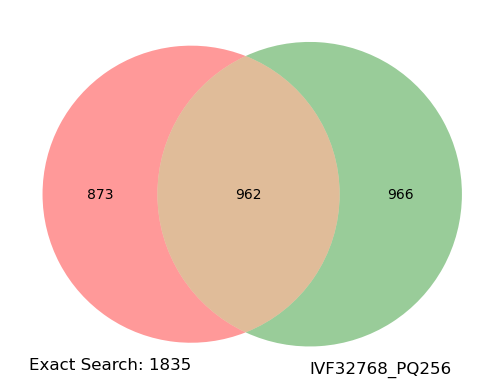

In [8]:
plot1(
    [1.06, 1.06],
    idx_a_k,
    idx_b_gt,
    idx_b_ann,
    margin_gt,
    margin_ann,
    self.index_factory_fn,
)

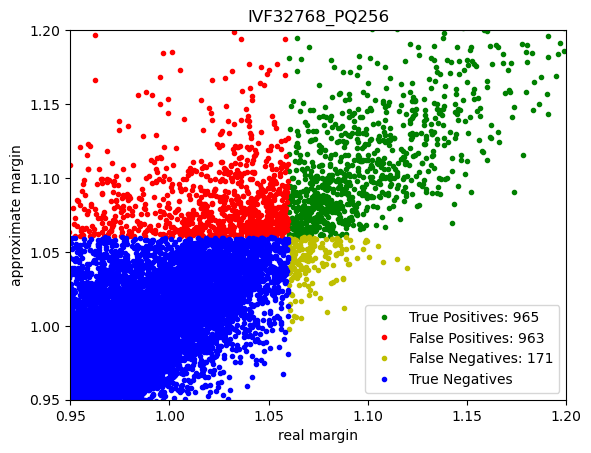

In [9]:
plot2(
    [1.06, 1.06],
    margin_refined,
    margin_ann,
    self.index_factory_fn,
    "real margin",
    "approximate margin",
)

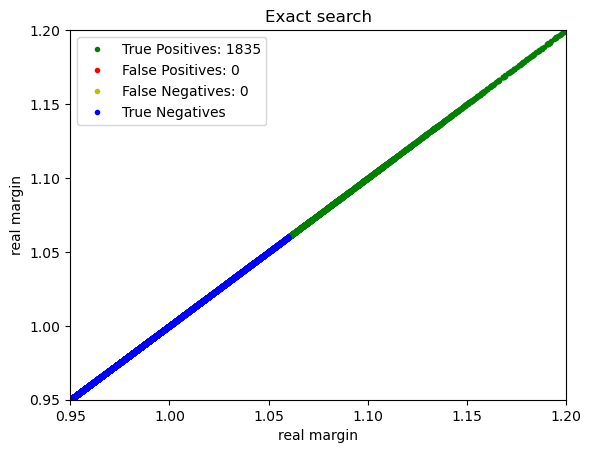

In [13]:
plot2([1.06, 1.06], margin_gt, margin_gt, "Exact search", "real margin", "real margin")

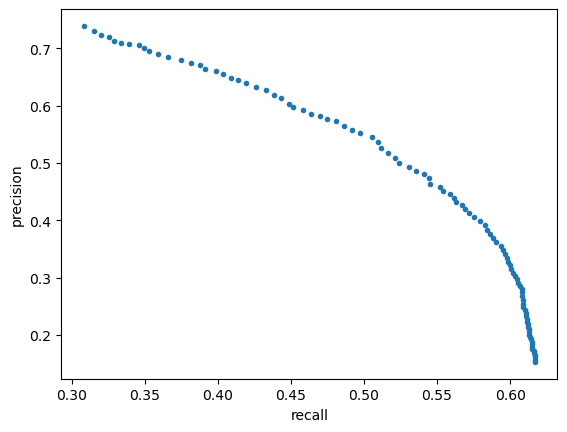

In [14]:
plot3(1.06, idx_a_k, idx_b_gt, idx_b_ann, margin_gt, margin_ann, self.index_factory_fn)